In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import re
from collections import Counter
from google.colab import drive

In [7]:
drive.mount('/content/drive')

# Read CSV
df = pd.read_csv('/content/poems-100.csv')

Mounted at /content/drive


In [8]:
df.head()

,text
0,"O my Luve's like a red, red rose\nThat’s newly..."
1,"The rose is red,\nThe violet's blue,\nSugar is..."
2,How do I love thee? Let me count the ways.\nI ...
3,"Had I the heavens' embroidered cloths,\nEnwrou..."
4,"I.\n Enough! we're tired, my heart and I.\n..."


In [9]:

# Extract only the poems content
poems = df['text'].dropna().tolist()

# Convert to lowercase and remove special characters
cleaned_poems = [re.sub(r"[^a-zA-Z\s]", "", poem.lower()) for poem in poems]

In [10]:
# Tokenization
all_words = [word for poem in cleaned_poems for word in poem.split()]
vocab = sorted(set(all_words))
vocab_size = len(vocab)
word_to_idx = {word: i for i, word in enumerate(vocab)}
idx_to_word = {i: word for word, i in word_to_idx.items()}


In [11]:
# Prepare dataset
seq_length = 2
input_data = []
target_data = []
for poem in cleaned_poems:
    words = poem.split()
    for i in range(len(words) - seq_length):
        input_data.append([word_to_idx[words[j]] for j in range(i, i+seq_length)])
        target_data.append(word_to_idx[words[i + seq_length]])

X = torch.tensor(input_data, dtype=torch.long)
y = torch.tensor(target_data, dtype=torch.long)

In [12]:
# Define RNN Model with Embeddings
class RNNWithEmbeddings(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super(RNNWithEmbeddings, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

In [13]:
# Initialize model
embed_size = 16
hidden_size = 16
model = RNNWithEmbeddings(vocab_size, embed_size, hidden_size, vocab_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [14]:
# Training loop
epochs = 500
losses = []
accuracies = []

for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    # Compute accuracy
    _, predicted = torch.max(output, 1)
    accuracy = (predicted == y).float().mean().item()
    accuracies.append(accuracy)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

Epoch 10/500, Loss: 7.8201, Accuracy: 0.0098
Epoch 20/500, Loss: 6.7520, Accuracy: 0.0326
Epoch 30/500, Loss: 6.4359, Accuracy: 0.0752
Epoch 40/500, Loss: 6.2779, Accuracy: 0.0809
Epoch 50/500, Loss: 6.0979, Accuracy: 0.0836
Epoch 60/500, Loss: 5.9201, Accuracy: 0.0870
Epoch 70/500, Loss: 5.7326, Accuracy: 0.0963
Epoch 80/500, Loss: 5.5372, Accuracy: 0.1081
Epoch 90/500, Loss: 5.3404, Accuracy: 0.1190
Epoch 100/500, Loss: 5.1476, Accuracy: 0.1310
Epoch 110/500, Loss: 4.9634, Accuracy: 0.1459
Epoch 120/500, Loss: 4.7900, Accuracy: 0.1624
Epoch 130/500, Loss: 4.6287, Accuracy: 0.1788
Epoch 140/500, Loss: 4.4800, Accuracy: 0.1954
Epoch 150/500, Loss: 4.3436, Accuracy: 0.2122
Epoch 160/500, Loss: 4.2196, Accuracy: 0.2266
Epoch 170/500, Loss: 4.1070, Accuracy: 0.2419
Epoch 180/500, Loss: 4.0056, Accuracy: 0.2558
Epoch 190/500, Loss: 3.9140, Accuracy: 0.2664
Epoch 200/500, Loss: 3.8319, Accuracy: 0.2771
Epoch 210/500, Loss: 3.7582, Accuracy: 0.2864
Epoch 220/500, Loss: 3.6915, Accuracy: 0.29

In [15]:
# Save model weights
torch.save(model.state_dict(), "rnn_embeddings_weights.pth")
print("Model weights saved as rnn_embeddings_weights.pth")


Model weights saved as rnn_embeddings_weights.pth


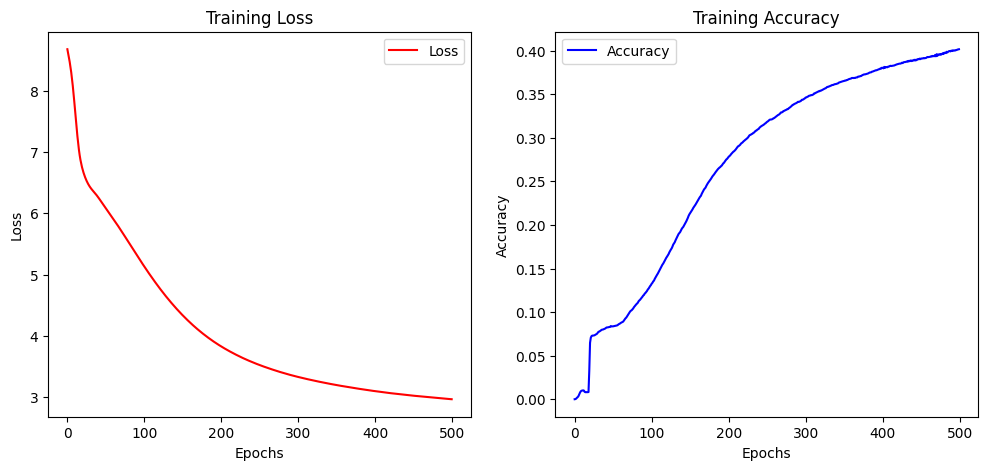

In [17]:
# Plot Loss and Accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.show()


In [18]:
# Generate text
def generate_text(start_word, length=5):
    model.eval()
    words = [start_word]
    for _ in range(length):
        input_seq = torch.tensor([[word_to_idx[words[-1]]]], dtype=torch.long)
        with torch.no_grad():
            output = model(input_seq)
            next_word = idx_to_word[torch.argmax(output).item()]
        words.append(next_word)
    return ' '.join(words)

print("Generated Text:", generate_text("love"))

Generated Text: love outward miles tis me flower
